# Making My Commute Just a Little Bit Better With A/B Testing

<hr>

### Background 
When I first started my job at Campaign Monitor, my commute changed significantly. I live on the northern side of Murfreesboro, which is roughly 35-40 minutes outside of Nashville, traffic excluded. For those of you that have experienced the ~~hell~~ unique traffic situation during commuting hours, you'll know that this is _not_ really how much time it takes. Depending on when I leave my house, I can expect a trip anywhere from 40 minutes (if there is, miraculously, no traffic) up to an hour and a half.

### The Premise
Usually, Google is suggesting the best (read, _quickest_ ) route from my house to work is to go through Smyrna and take 24-E. Disregarding traffic patterns this makes sense, because it's the most direct route at 29.9 miles. My hypothesis, however, is that taking the alternate route (840 to Mount Juliet and then 40W into Nashville) is actually quicker _during commute times_. As you can see on the map below, during normal times the alternate route (<font color='#EB4693'>**pink**</font>) is about 5 minutes slower than the direct route (<font color='#2561AC'>**blue**</font>) as it adds a little over 10 miles (or 34% extra distance).

<br>

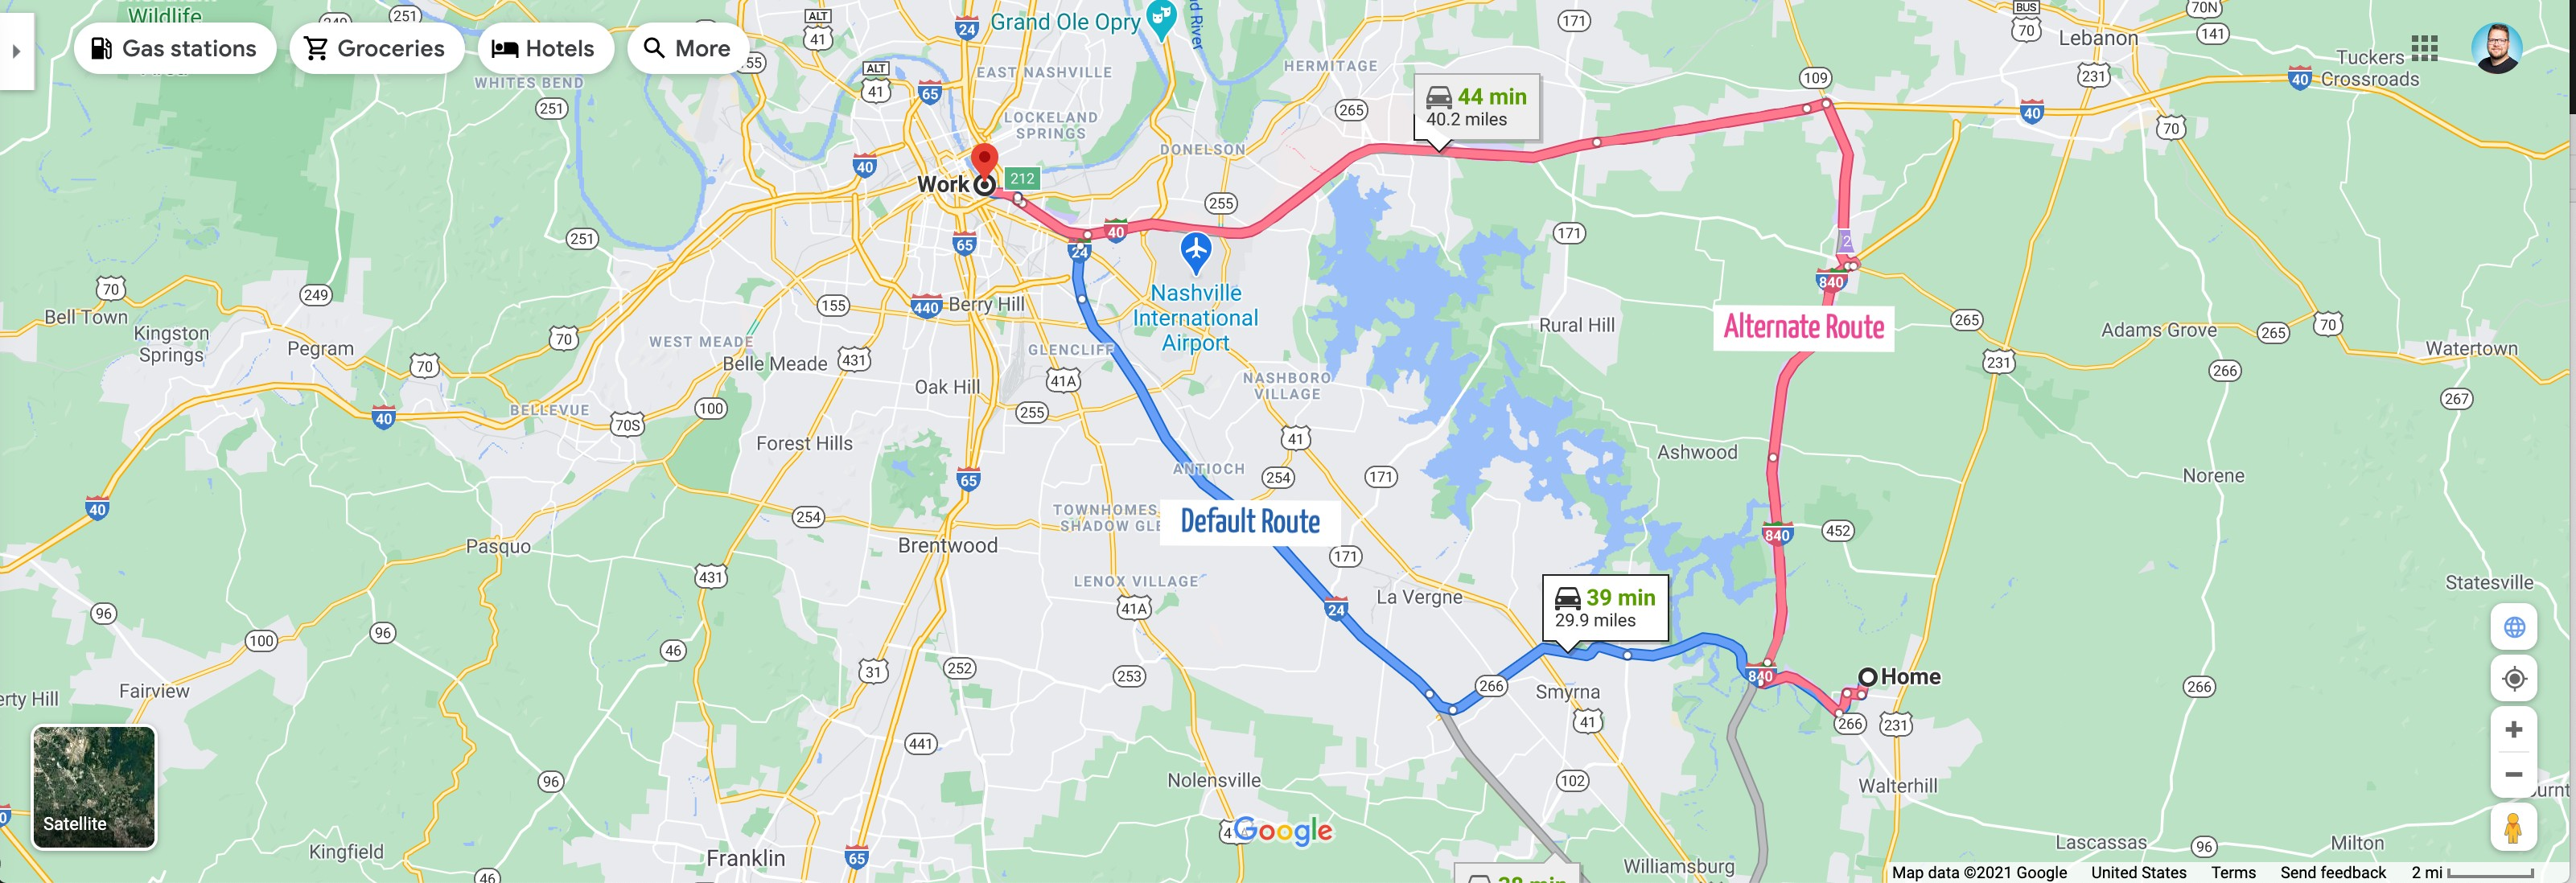


# Test Setup

In order to produce the data for this test, I am randomly taking either the default route (24E) or the alternate (840+40) over a span of several weeks until I have logged enough trips to have a large enough sample size for both groups. I tracked door-to-door time using an iphone app similar to [this one](https://www.timeanddate.com/ios/datecalculator/).
<br><br>


## Recall our A/B Testing Requirements

Let's first discuss if this even _is_ something that we can test using A/B testing?

1. **Is there a single variant?**
<br>Yes, there is a <font color='#2561AC'>**default route**</font> (control) and a single variant (<font color='#EB4693'>**alternate route**</font>). 
<br><br>
2. **Can users be randomly assigned?**
<br>Sort of, but let's say yes. I'm the one driving, so I did my best to just randomly decide which route to take every morning and afternoon.
<br><br>
3. **Do we have a target outcome to measure?**
<br>Yes, the target outcome is commute time in minutes.
<br><br>
4. **Can we define the sample size?**
<br>Yep. 


# Let's get Started

## Hypothesis

We want to run an A/B test to determine if there is a statistically significant difference between taking the default and alternate commuting routes. Therefore,

**Null Hypothesis:** There is no difference in taking the default and alternate routes.

**Alternative Hypothesis:** The alternate route is different in terms of commute time.

### Modules we need


In [1]:
import pandas as pd # for data manipulation and analysis
import numpy as np # for linear algebra and matrices
from scipy.stats import norm, stats # for statistics, normal distribution
from statsmodels.stats.power import tt_ind_solve_power # for sample size statistics
import matplotlib.pyplot as plt # for plotting
import statistics # Stdev function
import seaborn as sns # Pretty plots

from abtesting import power, min_sample_size # utility A/B funs from our own Michael Holloway!


%matplotlib inline

## The Data I collected 

#### The variables in the dataset are:

**Date** - date in m/d/yy format<br>
**Route** - binary target outcome variable; describes which route was taken (default or alternate)<br>
**Departure** - departure time<Br>
**Arrival** - arrival time<br>
**Gas.Start** - if gas stop was made, start of gas stop<br>
**Gas.End** - if gas stop was made, end of stop<br>
**Duration** - total trip duration in minutes<br>
**Duration.Fix** - total trip duration in minutes, normalized for gas stops<br>
**Daytime** - binary variable, either morning or evening commute<br>
**Weekday** - name of the weekday<br>
**Notes** - notes; denote unique days such as holiday weeks with less commuter traffic, etc.<br>
<br>

#### Get the results of your experiment by loading `matthias_commute.csv` from the /data folder

In [2]:
results = pd.read_csv('../data/matthias_commute.csv')
results.head()

,Date,Route,Departure,Arrival,Gas.Start,Gas.End,Duration,Duration.Fix,Daytime,Weekday,Notes
0,9/17/18,Default,4:51 PM,5:42 PM,NaN,NaN,51,51,Evening,Monday,NaN
1,9/17/18,Default,6:52 AM,8:05 AM,NaN,NaN,73,73,Morning,Monday,NaN
2,9/18/18,Alternate,6:35 PM,7:21 PM,7:00 PM,7:07 PM,46,39,Evening,Tuesday,NaN
3,9/18/18,Default,6:39 AM,7:55 AM,NaN,NaN,76,76,Morning,Tuesday,NaN
4,9/19/18,Alternate,4:09 PM,4:52 PM,NaN,NaN,43,43,Evening,Wednesday,NaN


#### For ease of use, let's create a dataframe for each test group

In [3]:
default_route = results.loc[results['Route'] == 'Default']
alternate_route = results.loc[results['Route'] == 'Alternate']

default_route_time = default_route['Duration.Fix']
alternate_route_time = alternate_route['Duration.Fix']

#### It's always a good idea to explore data visually ( _Exploratory Data Analysis_ ), so let's take a look at group distribution

Text(0.5, 1.0, 'Commute time Distribution by Route')

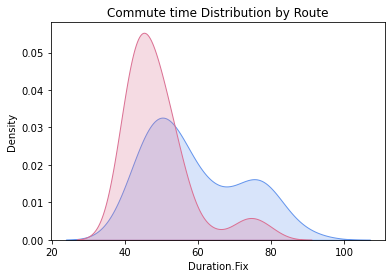

In [5]:
sns.kdeplot(default_route_time, shade=True, label="Default Route", color="cornflowerblue")
sns.kdeplot(alternate_route_time, shade=True, label="Alternate Route", color="palevioletred")
plt.title("Commute time Distribution by Route")

On First thought, I'm not _sure_ if the groups are different. Visually, it appears that the Alternate route is potentially a better way to commute, however, let's test this assumption mathematically.

# Running the A/B Test


## Significance Level

Recall from Training day 1 that we will want to set a significance level (**Question:** What is a significance level?) For this example, we'll use a significance level of 0.05.


## Sample Size

Checking Google in the morning and evenings, we determine that the average commute for the default route is somewhere arount 59 minutes during commute hours with a standard deviation of 13 minutes. Let's assume we want to be able to measure a difference of 8 minutes with certainty.

**Question:** What sample size do you need for your test to have 80% power? (What is power?) Is the sample that we have sufficient in order to achieve 80% power?


In [6]:
?tt_ind_solve_power

In [7]:
# The tt_ind_solve_power() from statsmodels requires the following parameters to calculate sample size:

# effect_size: Standardised effect size ie. difference between the two means divided by the standard deviation; this value has to be positive.
# alpha: Significance level
# power: Power of the test

mean_diff, sd_diff = 8, 13
std_effect_size = mean_diff / sd_diff

n = tt_ind_solve_power(effect_size=std_effect_size, alpha=0.05, power=0.8)
print('Number in *each* group: {:.5f}'.format(n))

Number in *each* group: 42.43387


This says that you we need 43 observations per variant. Let's check whether or not we have the needed sample size.

In [8]:
results.Route.value_counts()

Default      62
Alternate    55
Name: Route, dtype: int64

There are more than enough observations to achieve 80% power.

## Point Estimate

Let's look at the data set and calculate some point estimates. 

First, use `.groupby` to find the total commute time in our data set for each variant. Remember that we want to count `Duration.Fix` as this is the normalized commute time in minutes. Let's store those into a new data frame called `means`.

In [9]:
means = results.groupby('Route')['Duration.Fix'].agg(['sum', 'count'])
means.columns = ['total_commute_time', 'num_trips']
means

,total_commute_time,num_trips
Route,,
Alternate,2694,55
Default,3657,62


Using these two numbers can generate a point estimate for the average commute time by Route:

In [10]:
means['point_estimate'] = means['total_commute_time'] / means['num_trips']
means

,total_commute_time,num_trips,point_estimate
Route,,,
Alternate,2694,55,48.981818
Default,3657,62,58.983871


In [11]:
statistics.stdev(default_route_time)

13.035250990162037

In [12]:
statistics.stdev(alternate_route_time)

9.015400217263851

## Testing Statistical Significance
#### There's a ten minute difference in our test statistic. But how do we know this isn't just chance?

## Finding the p-value with the Student's T-Test

### Why the T-Test is Appropriate here

There are four requirements for the T-Test to be an appropriate application:

1. **We compare the means of two samples**
<br>Check! That's what we have. 
<br><br>
2. **Our true population mean and st. dev. are unknown**
<br>Also check, recall that we only have a sample statistic. Note that if we actually knew the population, we would run a Z-Test instead.
<br><br>
3. **We have a small sample size**
<br>Our sample _is_ relatively small, so we're good here.
<br><br>
4. **We assume that data is normally distributed**
<br>This would likely take too long to explain, but the Central Limit Theorem (CLT) states that if we take sufficiently large samples, then we can assume the distribution to be approximately _normal_. 
<br><br>

In [13]:
?stats.ttest_ind

In [14]:
tStat, pValue = stats.ttest_ind(default_route_time, alternate_route_time) #run independent sample T-Test
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat)) #print the P-Value and the T-Statistic

P-Value:5.512673332269224e-06 T-Statistic:4.76725009893074


In [15]:
print('%.08f' % pValue)

0.00000551


# Conclusion
Since the $p$-value is smaller than the significance level of 0.05, we *do* reject the null hypothesis in this case. There is clear evidence to conclude that there is a difference in commute times between default and alternate route. Going forward, I should take I840 and I40 instead of taking I24.

### Alternative: Finding the p-value with KS
We're comparing two means here, so the [Kolmogorov–Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) is a suitable, and very easy way of determining `p`

In [16]:
stats.ks_2samp(default_route['Duration.Fix'], alternate_route['Duration.Fix'])

KstestResult(statistic=0.38064516129032255, pvalue=0.0002622984447617771)

<hr>

# Your turn: 

Matthias _loves_ long weekends but doesn't know if he should take Monday of Friday off. Determine if there is statistically significant difference in commute time for Mondays and Fridays.

**Using a markdown cell**    
1. State the null and alternative hypotheses
2. What is the single variant (difference) between your A and B groups?
3. What is the target outcome to measure (your point statistic)?
4. Historically, commutes on Mondays take about 58 minutes with a standard deviation of 14 minutes. If you want to detect a 10 minute absolute difference, what sample size is needed for 80% power?
5. Do you have a sufficiently sized sample?    

**Using code cells**
1. Calculate the following for each group:  
    a. number of observations  
    b. total commuting minutes
    c. average (mean) commute time 
2. Determine the p-value.

**State your conclusion**  
1. Will accept or reject the null hypothesis?
2. What led you to your conclusion?
3. What other factors might you consider in making a final decision of which day(s) to take off?